## Preparing the raw data

Let's clean up and transform the data to fit this specification:

(which appears to be a good model from the start, as we see later)

PropertyCrime = α + Population + Population^2 + Murder + Robbery

In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
import statsmodels.formula.api as smf

In [2]:
df = pd.read_excel('../NY_crime2013.xlsx', skiprows=4)

In [3]:
df.head(5)

,City,Population,Violent_crime,Murder,Rape_1,Rape_2,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny- theft,Motor_vehicle_theft,Arson3
0,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN
4,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN


## Creating features and building the regression model

In [4]:
df['Population^2'] = df['Population'] * df['Population']

In [5]:
df.loc[df['Property_crime'] > 100000]

,City,Population,Violent_crime,Murder,Rape_1,Rape_2,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny- theft,Motor_vehicle_theft,Arson3,Population^2
216,New York,8396126,52384,335,NaN,1112,19170,31767,141971,16606,117931,7434,NaN,70494931807876


In [6]:
df.loc[df['Murder'] > 0, 'Murder_bol'] = 1
df.loc[df['Robbery'] > 0, 'Robbery_bol'] = 1
df.loc[df['Arson3'] > 0, 'Arson3_bol'] = 1

In [7]:
data = df[['Population','Population^2','Murder_bol','Robbery_bol', 'Property_crime' ,'Burglary', 'Murder', 'Robbery','Arson3' ,'Motor_vehicle_theft']]


In [8]:
data_XY_noNaN = data[['Population','Population^2','Murder_bol','Robbery_bol', 'Property_crime']].dropna(axis=0, how='any')
# data['sqrtMurder'] = [math.sqrt(x) for x in data['Murder']]

X = data_XY_noNaN[['Population','Population^2','Murder_bol','Robbery_bol']]
Y = data_XY_noNaN['Property_crime']

The best performing regression model
Population, Population^2, Murder and Robbery

Coefficients: 
 [  3.94061095e-02  -2.67340744e-09   0.00000000e+00   0.00000000e+00]

Intercept: 
 -424.825849014

R-squared:
0.99696162361


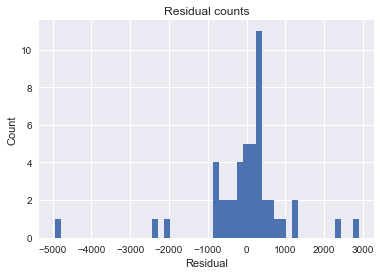

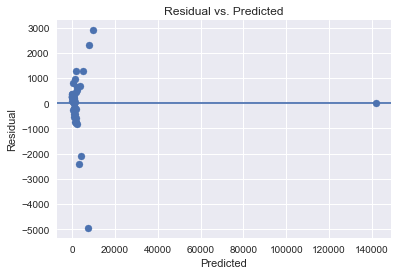

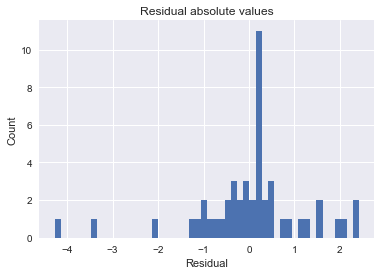

In [9]:
print('The best performing regression model')
print('Population, Population^2, Murder and Robbery')
regr = linear_model.LinearRegression()
regr.fit(X, Y) 
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
predicted = regr.predict(X)
actual = Y
residual = actual - predicted
rel_residual = residual / actual
plt.hist(residual, bins = 50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()


plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

residual_r = rel_residual.loc[abs(rel_residual) != np.inf]
plt.hist(residual_r, bins = 50)
plt.title('Residual absolute values')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

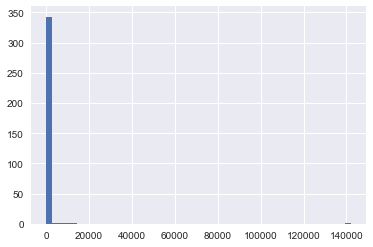

In [10]:
df.Property_crime.hist(bins=50)

In [11]:
df.loc[data['Property_crime'] > 100000]

,City,Population,Violent_crime,Murder,Rape_1,Rape_2,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny- theft,Motor_vehicle_theft,Arson3,Population^2,Murder_bol,Robbery_bol,Arson3_bol
216,New York,8396126,52384,335,NaN,1112,19170,31767,141971,16606,117931,7434,NaN,70494931807876,1.0,1.0,NaN


The entiry above (NYC) is an outlier. Let's run a model without it and see our real R squared. 

### Same model excluding the outlier

In [12]:
data_wNYC = data_XY_noNaN.loc[data_XY_noNaN['Property_crime'] < 100000]

In [13]:
X = data_wNYC[['Population', 'Murder_bol','Robbery_bol']]
Y = data_wNYC['Property_crime']

Population, Population^2, Murder and Robbery without NYC data

Coefficients: 
 [ 0.03887747  0.          0.        ]

Intercept: 
 -412.579669611

R-squared:
0.776201729956


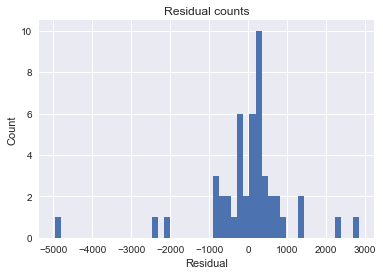

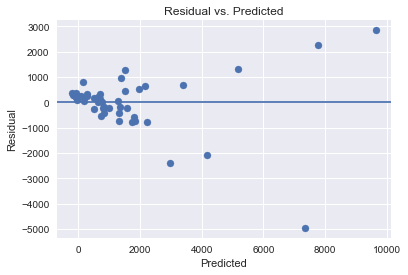

In [14]:
print('Population, Population^2, Murder and Robbery without NYC data')
regr = linear_model.LinearRegression()
regr.fit(X, Y) 
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
predicted = regr.predict(X)
actual = Y
residual = actual - predicted
plt.hist(residual, bins = 50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

R-squared of 0.85 is a pretty good one. We'll stop exploring here.

## Feature evaluation and validation via statsmodels library

In [15]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [16]:
linear_formula = 'Property_crime ~ Population + Population^2 + Murder_bol + Robbery_bol'
lm = smf.ols(formula=linear_formula, data=data_wNYC).fit()
print('Formula parameters')
print(lm.params)

print('Pvalues of parameters')
print(lm.pvalues)
print('R-squared: ' + str(lm.rsquared))

Formula parameters
Intercept        -140.534506
Population        -30.099307
Population ^ 2     30.138337
Murder_bol       -140.534506
Robbery_bol      -140.534506
dtype: float64
Pvalues of parameters
Intercept         0.077749
Population        0.725477
Population ^ 2    0.725137
Murder_bol        0.077749
Robbery_bol       0.077749
dtype: float64
R-squared: 0.776836800039


In [19]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Property_crime   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     76.58
Date:                Mon, 07 May 2018   Prob (F-statistic):           4.67e-15
Time:                        09:36:30   Log-Likelihood:                -396.65
No. Observations:                  47   AIC:                             799.3
Df Residuals:                      44   BIC:                             804.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -140.5345     77.812     -1.806      0.078    -297.354      16.285
Population       -30.0993     85.171     -0.353      0.725    -201.750     141.551
Population ^ 2    30.1383     85.171      0.354      0.725    -141.513     201.790
Murder_bol      -140.5345     77.812     -1.806      0.078    -297.354      16.285
Robbery_bol     -140.5345     77.812     -1.806      0.078    -297.354      16.285
==============================================================================
Omnibus:                       32.180   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.520
Skew:                          -1.603   Prob(JB):                     3.03e-26
Kurtosis:                      10.052   Cond. No.                     2.98e+36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.77e-62. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
print('cross-validation: ' + str(cross_val_score(linear_model.LinearRegression(), X, Y, cv=10)))
cross_val_1 = cross_val_score(linear_model.LinearRegression(), X, Y, cv=10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [ ]:
print('With 20% Holdout: ' + str(linear_model.LinearRegression().fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(linear_model.LinearRegression().fit(X, Y).score(X, Y)))

## Validation using another set of data (NY crimes 2014)

In [ ]:
df_2014 = pd.read_excel('../NY_crime2014.xlsx')

In [ ]:
df_2014.head(2)

In [ ]:
df_2014['Population^2'] = df_2014['Population'] * df_2014['Population']

In [ ]:
df_2014.loc[df_2014['Murder'] > 0, 'Murder_bol'] = 1
df_2014.loc[df_2014['Robbery'] > 0, 'Robbery_bol'] = 1
df_2014.loc[df_2014['Arson3'] > 0, 'Arson3_bol'] = 1

In [ ]:
data_2014 = df_2014[['Population','Population^2','Murder_bol','Robbery_bol', 'Property_crime' ,'Burglary','Murder','Robbery','Arson3','Motor_vehicle_theft']]
data_XY_noNaN_2014 = data_2014[['Population','Population^2','Murder_bol','Robbery_bol', 'Property_crime']].dropna(axis=0, how='any')


In [ ]:
data_wNYC_2014 = data_XY_noNaN_2014.loc[data_XY_noNaN_2014['Property_crime'] < 100000]

In [ ]:
X_2014 = data_wNYC_2014[['Population','Population^2','Murder_bol','Robbery_bol']]
Y_2014 = data_wNYC_2014['Property_crime']

In [ ]:
print('Testing on Sample of 2014: \n ' + str(linear_model.LinearRegression().fit(X, Y).score(X_2014, Y_2014)))

In [ ]:
## what is -2.67055006? 
## am I doing the cross-valuation correctly? 

In [ ]:
predicted_2014 = regr.predict(X_2014)
actual_2014 = Y_2014
residual_2014 = actual_2014 - predicted_2014
plt.hist(residual_2014, bins = 50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()
plt.scatter(predicted_2014, residual_2014)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Focusing on predicting data for Property crime < 6000
### more focused analysis


In [ ]:
data_wNYC = data_XY_noNaN.loc[data_XY_noNaN['Property_crime'] < 6000]
X = data_wNYC[['Population','Population^2','Murder_bol','Robbery_bol']]
Y = data_wNYC['Property_crime']

print('Population, Population^2, Murder and Robbery without NYC data')
regr = linear_model.LinearRegression()
regr.fit(X, Y) 
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
predicted = regr.predict(X)
actual = Y
residual = actual - predicted
plt.hist(residual, bins = 50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


In [ ]:
data_wNYC_2014 = data_XY_noNaN_2014.loc[data_XY_noNaN_2014['Property_crime'] < 6000]
X_2014 = data_wNYC_2014[['Population','Population^2','Murder_bol','Robbery_bol']]
Y_2014 = data_wNYC_2014['Property_crime']
print('Testing on Sample of 2014: \n ' + str(linear_model.LinearRegression().fit(X, Y).score(X_2014, Y_2014)))

In [ ]:
predicted_2014 = regr.predict(X_2014)
actual_2014 = Y_2014
residual_2014 = actual_2014 - predicted_2014
plt.hist(residual_2014, bins = 50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()
plt.scatter(predicted_2014, residual_2014)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Revised model

In [ ]:
new_model = data[['Population', 'Robbery', 'Burglary', 'Arson3', 'Property_crime' ,'Motor_vehicle_theft']].dropna(axis=0, how='any')
new_model_no_big = new_model.loc[new_model['Property_crime'] < 6000]
X = new_model_no_big[['Population', 'Robbery', 'Burglary', 'Arson3','Motor_vehicle_theft']]
Y = new_model_no_big['Property_crime']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(linear_model.LinearRegression().fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(linear_model.LinearRegression().fit(X, Y).score(X, Y)))

In [ ]:
cross_val_score(linear_model.LinearRegression(), X, Y, cv=10)

In [ ]:
cross_val_2 = cross_val_score(linear_model.LinearRegression(), X, Y, cv=10)
## use np.arange(start, end, step) for plotting
plt.hist(cross_val_1, bins = 20, alpha = 0.5, color = 'r')
plt.hist(cross_val_2, bins = 5, alpha = 0.5, color = 'b')
plt.show()

In [ ]:
new_model_2014 = data_2014[['Population','Robbery', 'Burglary', 'Arson3', 'Property_crime','Motor_vehicle_theft']].dropna(axis=0, how='any')
new_model_no_big_2014 = new_model.loc[new_model['Property_crime'] < 6000]

X_2014 = new_model_no_big_2014[['Population', 'Robbery','Burglary', 'Arson3','Motor_vehicle_theft']]
Y_2014 = new_model_no_big_2014['Property_crime']
print('Testing on Sample of 2014: \n ' + str(linear_model.LinearRegression().fit(X, Y).score(X_2014, Y_2014)))

In [ ]:
print('Population,  Burglary, Arson3, Robbery and Motor_vehicle_theft without big cities data')
regr = linear_model.LinearRegression()
regr.fit(X, Y) 
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
predicted = regr.predict(X)
actual = Y
residual = actual - predicted
plt.hist(residual, bins = 50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Why to use these features:
- not bi-polar coef for the same feature: coef for Population was positive, for Population^2 - negative 
- features related to property crime